# Flower Classification

In [2]:
# Load libraries 
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from warnings import filterwarnings

In [3]:
# Set styling matplotlib
plt.style.use("ggplot")

In [4]:
# Set pandas interface
pd.set_option("display.max_rows", None)

In [5]:
# Set warnings levels
filterwarnings("ignore")

## Feature Engineering

In [6]:
# Define folder and classes
folder_path = "dataset/flowers_dataset/"
classes     = os.listdir(folder_path)

# Overview class in flower dataset
classes

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

In [7]:
# Define blank array and label to store dataset
image_array = []
image_labels = []
list_filename = []

In [8]:
# Iter each folder and assign as array
for label in tqdm(os.listdir(folder_path)):
    folder_label = os.path.join(folder_path,  label)
    for fn in os.listdir(folder_label):
        filename = os.path.join(folder_label, fn)
        img = cv.imread(filename)[:, :, ::-1]
        img = cv.resize(img, (50, 50))
        image_array.append(img.flatten())
        image_labels.append(label)
        list_filename.append(filename)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.79s/it]


In [9]:
# Convert list into np.array object
image_array = np.array(image_array)
image_label = np.array(image_labels)

# Check dimension
image_array.shape, image_label.shape

((5000, 7500), (5000,))

In [10]:
# Assign as dataframe
data = pd.DataFrame(image_array)
data.columns = [f"pixel_{i}" for i in data.columns]
data['label'] = image_label

# Check dimension
data.shape

(5000, 7501)

## Exploratory Data Analysis

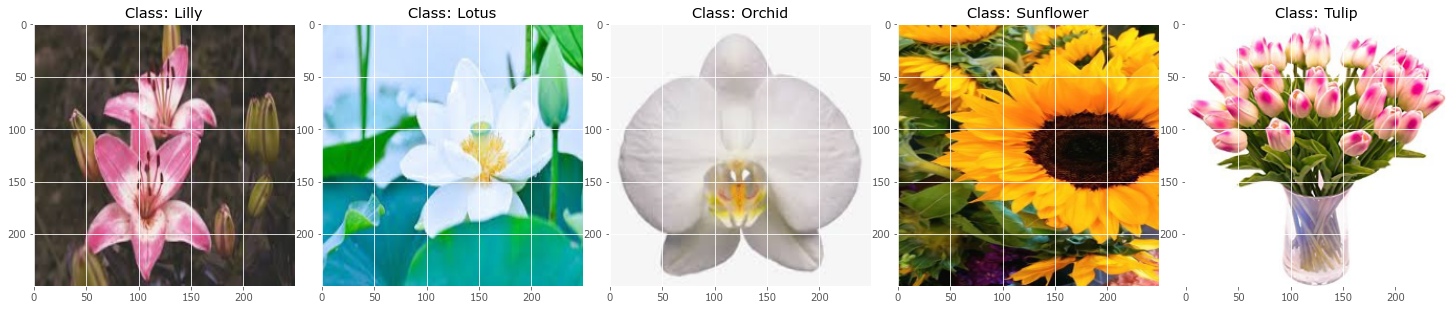

In [11]:
# Overview sample image on each class as figure
row, col = 1, 5
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col in range(col):
    cls = classes[count]
    filename = list_filename[image_labels.index(cls)]
    image = cv.imread(filename)[:, :, ::-1]
    image = cv.resize(image, (250, 250))
    ax[n_col].imshow(image)
    ax[n_col].set_title(f"Class: {cls}")
    count += 1
        
plt.tight_layout(pad=0);

In [12]:
# Overview label distribution
label_dist = pd.DataFrame(pd.Series(image_labels).value_counts()).reset_index()
label_dist.columns = ['Flower Class', 'Count']
label_dist

# NOTE: distribution of each label is equal a.k.a balance, so we dont need to apply augmentation technique.

,Flower Class,Count
0,Lilly,1000
1,Lotus,1000
2,Orchid,1000
3,Sunflower,1000
4,Tulip,1000


## Data Preprocessing

In [13]:
# Load libraries 
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

![](https://miro.medium.com/v2/resize:fit:1400/1*ba0XpZtJrgh7UpzWcIgZ1Q.jpeg)

In [14]:
# Perform PCA to reduce pixel value feature
pca = PCA()
pca.fit(data.drop("label", axis = 1))

PCA()

In [50]:
# Variance ratio explained on each principal component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance)

# Reduce dimension with step sampling
idx, _cumulative_variance = [], []
for i in range(100, len(cumulative_variance) + 100, 100):
    _cumulative_variance.append(cumulative_variance[i - 1])
    idx.append(i)

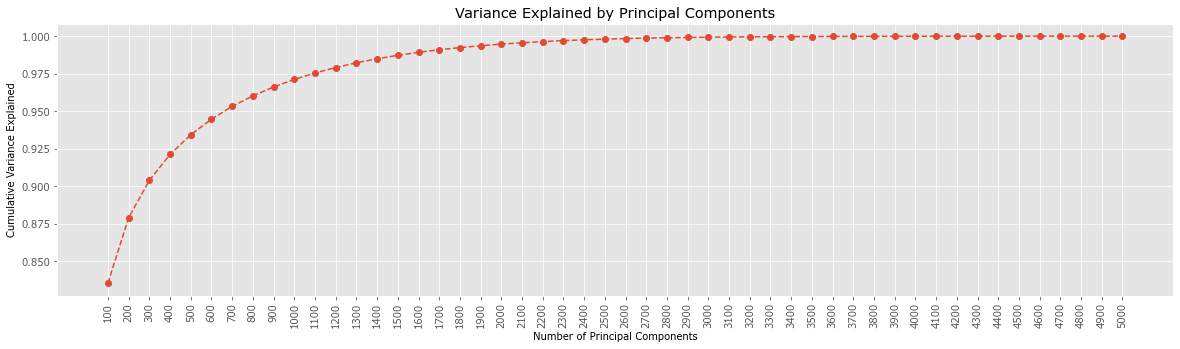

In [53]:
# Plot variance explained
plt.figure(figsize = (20, 5))
plt.plot(idx, _cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.xticks(idx, rotation = 90)
plt.show()

In [54]:
# Transform string label into numerical using Label Encoder method
encoder = LabelEncoder()
labels_encoder = encoder.fit_transform(image_labels)

In [55]:
# Overview label transformation result
pd.DataFrame({
    "Label Original": image_labels, 
    "Label Encoded" : labels_encoder
}).drop_duplicates()

,Label Original,Label Encoded
0,Lilly,0
1000,Lotus,1
2000,Orchid,2
3000,Sunflower,3
4000,Tulip,4


![](https://miro.medium.com/v2/resize:fit:948/1*4G__SV580CxFj78o9yUXuQ.png)

In [56]:
# Define feature 
features = image_array

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoder, test_size = 0.2, random_state = 1)

## Check dimension
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 7500), (1000, 7500), (4000,), (1000,))

## Data Modeling

In [57]:
# !pip install pretty-confusion-matrix

In [58]:
# Load libraries
from sklearn.svm import SVC
from pretty_confusion_matrix import pp_matrix
from sklearn.metrics import classification_report, confusion_matrix

## Baseline Algorithm

In [59]:
# Define algorithm
model_svm_baseline = SVC()
model_svm_baseline.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [60]:
# Training Algorithm
model_svm_baseline.fit(X_train, y_train)

SVC()

In [62]:
# Test on Training Set - classication_report
pred = model_svm_baseline.predict(X_train)
print(classification_report(y_train, pred, target_names = classes))

              precision    recall  f1-score   support

       Lilly       0.78      0.84      0.81       803
       Lotus       0.83      0.83      0.83       782
      Orchid       0.84      0.81      0.82       806
   Sunflower       0.92      0.93      0.93       802
       Tulip       0.87      0.82      0.85       807

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



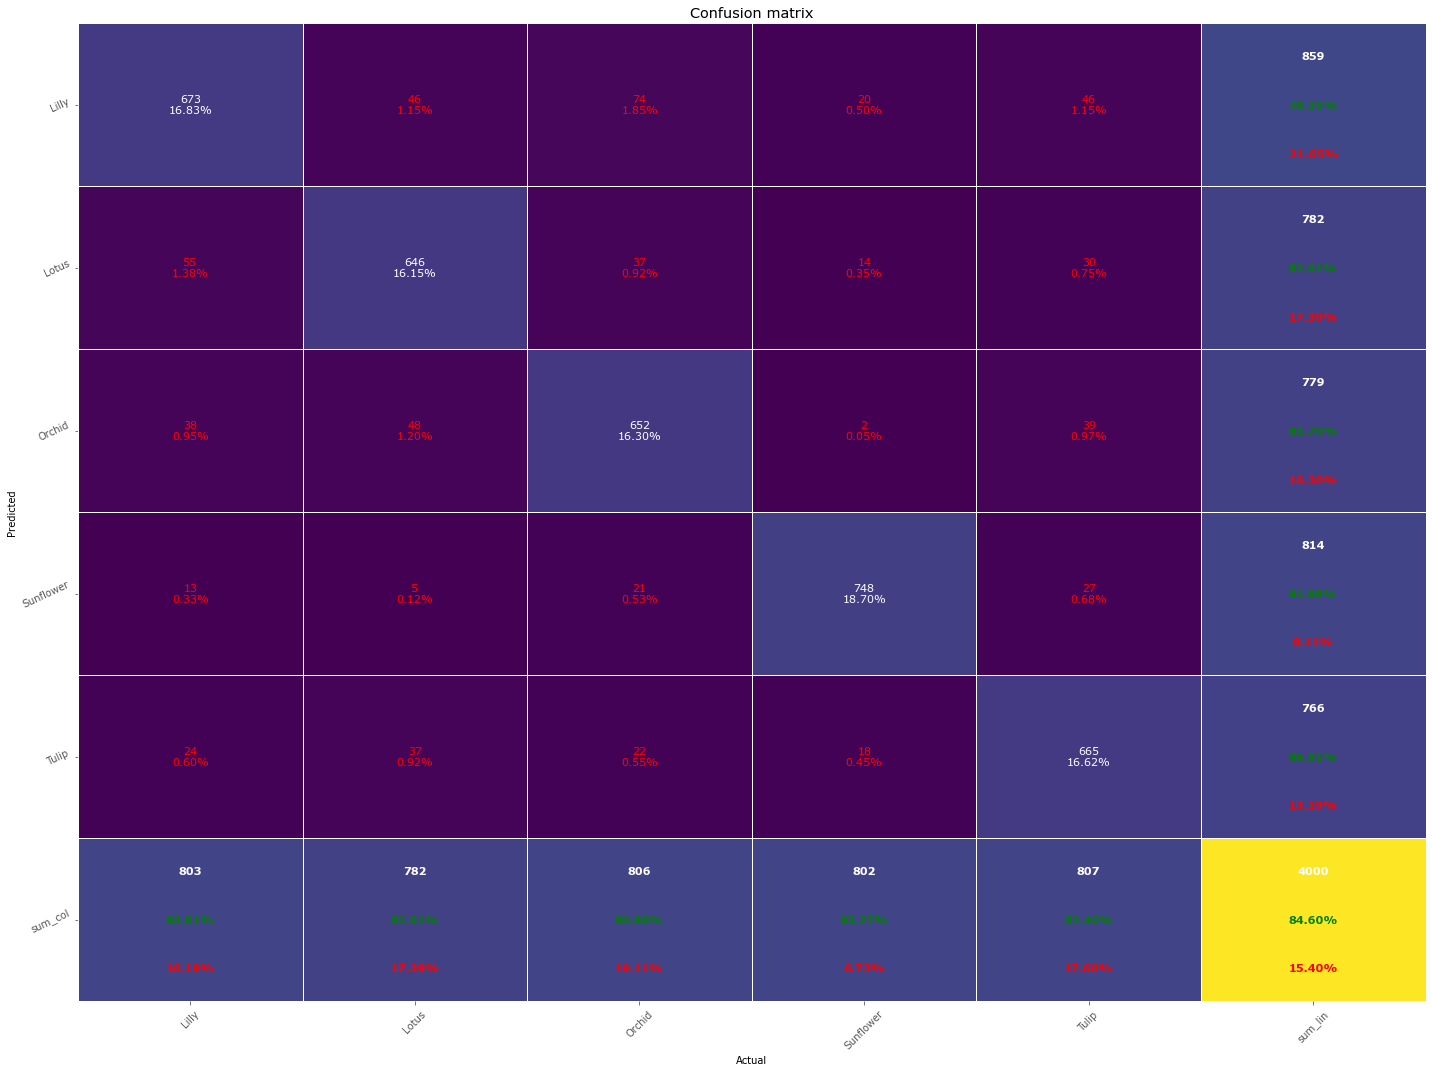

In [64]:
# Test on Training Set - confusion_matrix
array = confusion_matrix(y_train, pred)
array_df = pd.DataFrame(array, index = classes, columns = classes)
pp_matrix(array_df, cmap = "viridis", figsize = (20, 15))

In [65]:
# Test on Testing Set - classication_report
pred = model_svm_baseline.predict(X_test)
print(classification_report(y_test, pred, target_names = classes))

              precision    recall  f1-score   support

       Lilly       0.57      0.55      0.56       197
       Lotus       0.65      0.69      0.67       218
      Orchid       0.61      0.60      0.60       194
   Sunflower       0.81      0.79      0.80       198
       Tulip       0.66      0.65      0.66       193

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



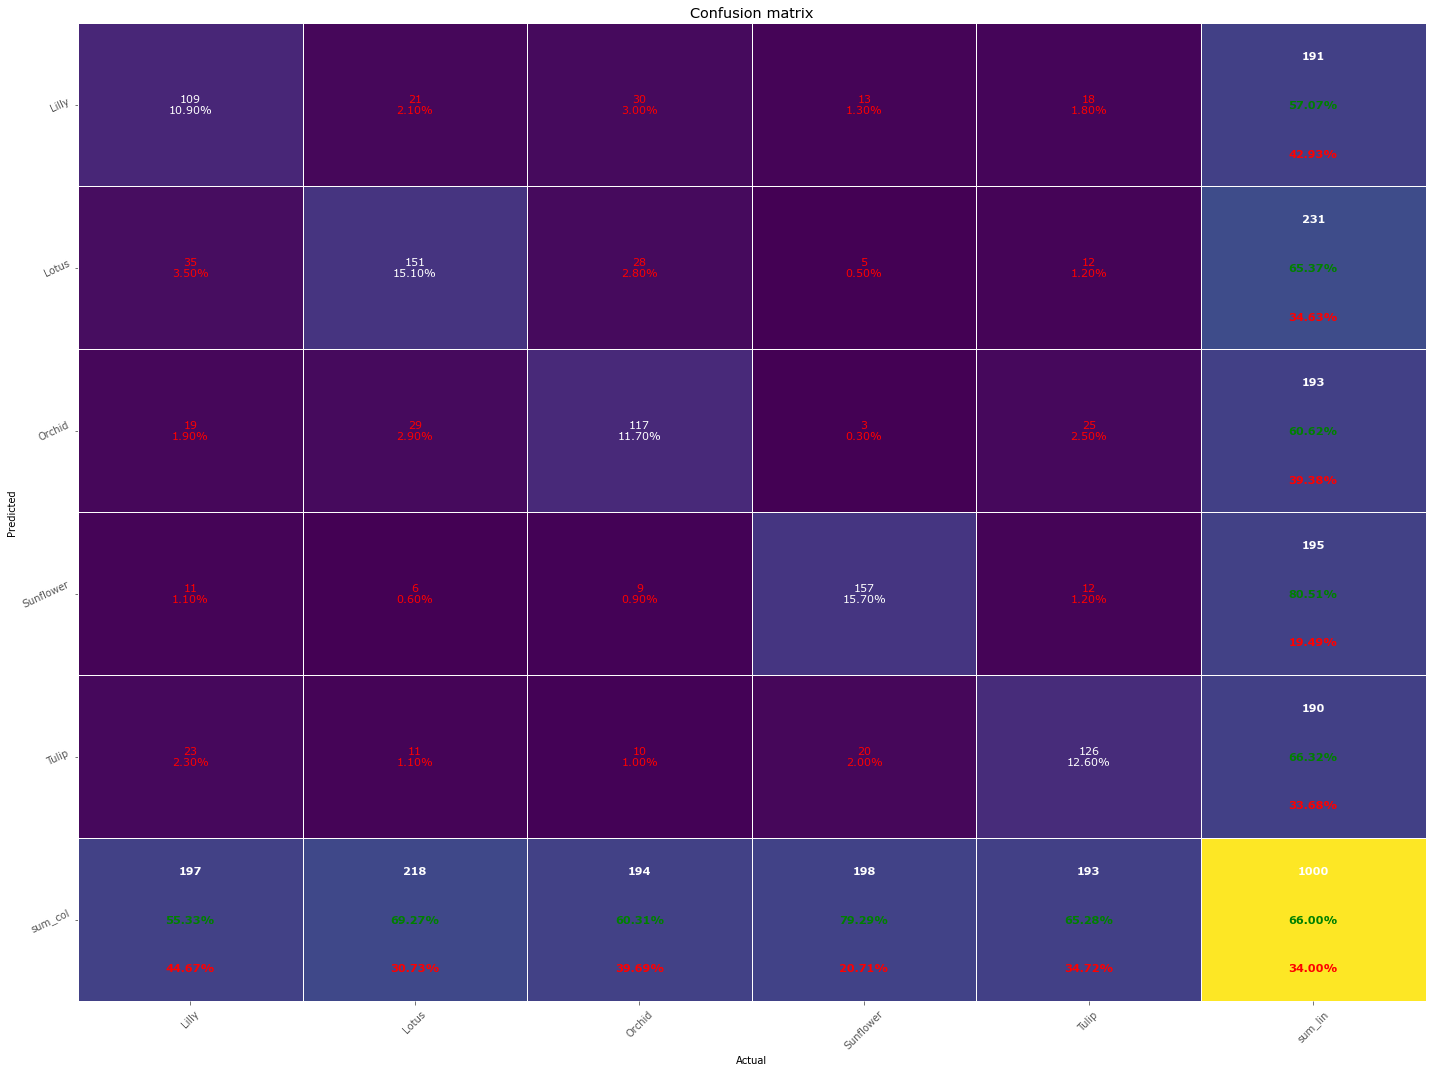

In [66]:
# Test on Testing Set - confusion_matrix
array = confusion_matrix(y_test, pred)
array_df = pd.DataFrame(array, index = classes, columns = classes)
pp_matrix(array_df, cmap = "viridis", figsize = (20, 15))

## Tuning Algorithm

![](https://journals.plos.org/plosone/article/figure/image?size=medium&id=10.1371/journal.pone.0235885.t001)

In [69]:
# Define list kernel
list_kernels = ["linear", "poly", "rbf", "sigmoid"]

In [70]:
# Define blank list to store metrics value
list_acc, list_pre, list_re, list_f1 = [], [], [], []

In [72]:
# Iter each kernel and apply on SVM algorithm
for kernel in list_kernels:
    svm_tuning = SVC(kernel=kernel)
    svm_tuning.fit(X_train, y_train)
    preds = svm_tuning.predict(X_test)
    metrics = classification_report(y_test, preds, output_dict = True)
    list_acc.append(metrics['accuracy'])
    list_pre.append(metrics['weighted avg']['precision'])
    list_re.append(metrics['weighted avg']['recall'])
    list_f1.append(metrics['weighted avg']['f1-score'])

In [73]:
# Wrap as dataframe metrics
metrics_final = pd.DataFrame({
    "SVM Kernels" : list_kernels, 
    "Accuracy"    : list_acc, 
    "Precision"   : list_pre, 
    "Recall"      : list_re, 
    "F1-Score"    : list_f1
})

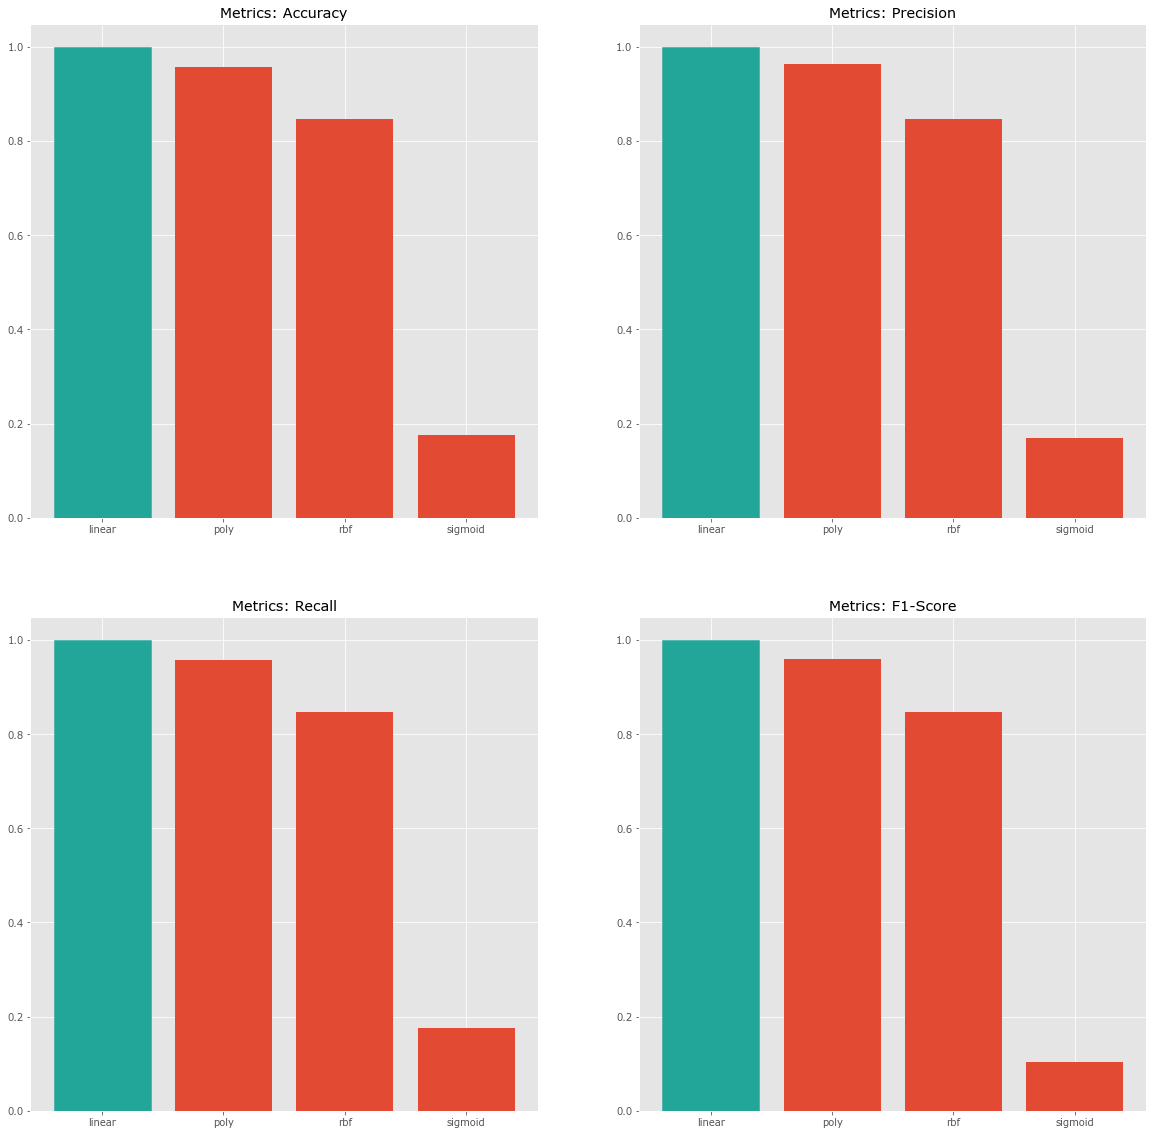

In [75]:
# Visualize metrics comparison
n_rows, n_cols = 2, 2
count = 0
fig, ax = plt.subplots(n_rows, n_cols, figsize = (20, 20))
list_metrics = metrics_final.columns[1:]

for row in range(n_rows):
    for col in range(n_cols):
        bar = ax[row, col].bar(x = list(range(1, 5)), height = metrics_final[list_metrics[count]])
        ax[row, col].set_xticks(list(range(1, 5)), list_kernels)
        ax[row, col].set_title(f"Metrics: {list_metrics[count]}")
        bar[0].set_color("#22A699")
        count += 1

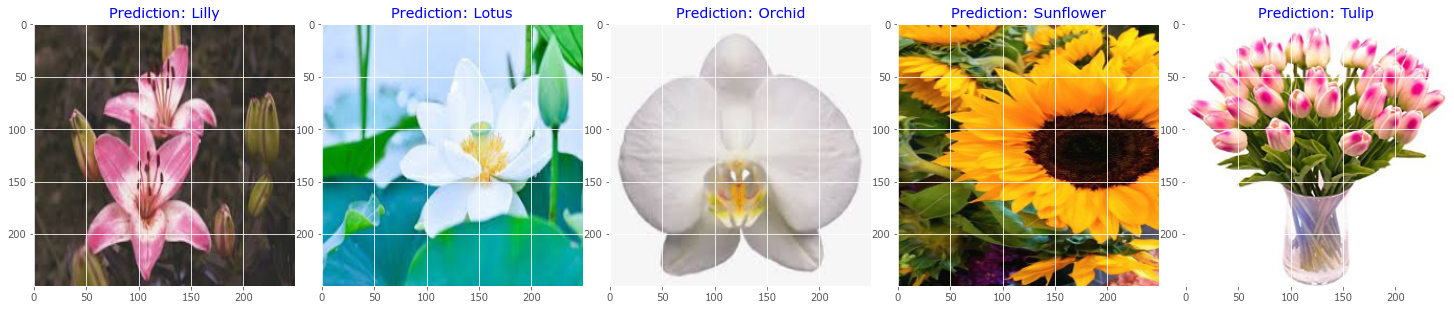

In [80]:
# Overview sample image on each class as figure
row, col = 1, 5
count    = 0
fig, ax = plt.subplots(row, col, figsize = (20, 15))

for n_col in range(col):
    cls = classes[count]
    filename = list_filename[image_labels.index(cls)]
    image = cv.imread(filename)[:, :, ::-1]
    image = cv.resize(image, (250, 250))
    
    n_feature     = data[data['label'] == cls].drop('label', axis = 1).iloc[0]
    preds_encoder = model_svm_baseline.predict([n_feature])
    preds_label   = encoder.inverse_transform(preds_encoder)[0]
    
    ax[n_col].imshow(image)
    ax[n_col].set_title(f"Prediction: {preds_label}")
    ax[n_col].title.set_color("blue" if preds_label == cls else "red")
    count += 1
        
plt.tight_layout(pad=0);
# NOTE: Blue color indicate "correct" prediction